# **RESNET152V2 Deep Learning Model training tutorial on Kaggle Child Chest X-rays augmented dataset - 97% accuracy**

The normal images from the dataset have been augmented - some of them where shifted right by 10px, some of them shifted left by 10px and some of them where slightly rotated. You can make these or similar adjustements, or you can train the model directly on the dataset, but augmenting the dataset can improve the accuracy of the model, as the dataset in its raw form is imbalanced ( approx. 3 pneumonia images for 1 normal image). After augmentation, my dataset is balanced with approx. 1 normal image for 1 pneumonia image. The augmentation and data preprocessing can be made in other ways too :) .

Also, it is assumed that you have uploaded the kaggle dataset in your drive. You can change the paths for the folders to suit you. I hope this tutorial will be helpful !

--Dannya

In [4]:
#helper code to see the number of files in a folder

import os

folder_path = '/content/drive/MyDrive/CHILD_XRAYS/chest_xray/train/NORMAL'

files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
file_count = len(files)

print(f"There are {file_count} files in the folder.")


There are 2854 files in the folder.


We import the necessary libraries.

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential


We load the dataset.

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/CHILD_XRAYS/chest_xray/train',
    target_size=(224, 224),  # ResNet-152V2 input size
    batch_size=32,
    class_mode='binary'
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/CHILD_XRAYS/chest_xray/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/CHILD_XRAYS/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5846 images belonging to 2 classes.
Found 834 images belonging to 2 classes.
Found 1669 images belonging to 2 classes.


In [5]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
).repeat()

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

We build and compile the model.

In [8]:
# Load the ResNet-152V2 model
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)             │ (None, 7, 7, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,022,273 (320.52 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

Train the model with 30 epochs. In the second epoch i get a "Your input ran out of data" error and the even numbered epochs lasted shorter. I still couldn't find an explanation for this, but the model provided very good accuracy when tested.

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a checkpoint to save the best model during training
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/CHILD_XRAYS/chest_xray/best_resnet152v2_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Train the ResNet-152V2 model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=30,
    callbacks=[checkpoint]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


182/182 ━━━━━━━━━━━━━━━━━━━━ 3319s 17s/step - accuracy: 0.8794 - loss: 3.4141 - val_accuracy: 0.9651 - val_loss: 0.0829
Epoch 2/30
  1/182 ━━━━━━━━━━━━━━━━━━━━ 46s 255ms/step - accuracy: 0.9062 - loss: 0.1857

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9062 - loss: 0.1857 - val_accuracy: 1.0000 - val_loss: 1.7812e-05
Epoch 3/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 127s 675ms/step - accuracy: 0.9699 - loss: 0.0838 - val_accuracy: 0.9591 - val_loss: 0.1201
Epoch 4/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.9688 - loss: 0.2724 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 5/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 123s 578ms/step - accuracy: 0.9768 - loss: 0.0761 - val_accuracy: 0.9651 - val_loss: 0.0853
Epoch 6/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 1.0000 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 5.2333e-04
Epoch 7/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 107s 572ms/step - accuracy: 0.9816 - loss: 0.0579 - val_accuracy: 0.9675 - val_loss: 0.0971
Epoch 8/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 1.0000 - loss: 0.0327 - val_accuracy: 1.0000 - val_loss: 4.5496e-04
Epoch 9/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 144s 579ms/step - accuracy: 0.9850 - loss: 0

Let's test the model.

In [7]:
from tensorflow.keras.models import load_model

best_model = load_model('/content/drive/MyDrive/CHILD_XRAYS/chest_xray/best_resnet152v2_model.keras')


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

In [11]:
# Get predictions
y_pred = best_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred_classes = np.where(y_pred > 0.5, 1, 0)  # Convert probabilities to binary classes (0 or 1)

# Get true labels
y_true = test_generator.classes

53/53 ━━━━━━━━━━━━━━━━━━━━ 976s 18s/step


# **CONFUSION MATRIX**

The confusion matrix provides a comprehensive view of our model’s performance by showing where it performs well and where it makes errors. For example:

* A high number of False Negatives (FN) indicates that the model is failing to detect positive cases, which can be critical in medical applications.
* A high number of False Positives (FP) may lead to unnecessary further testing or anxiety for patients.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

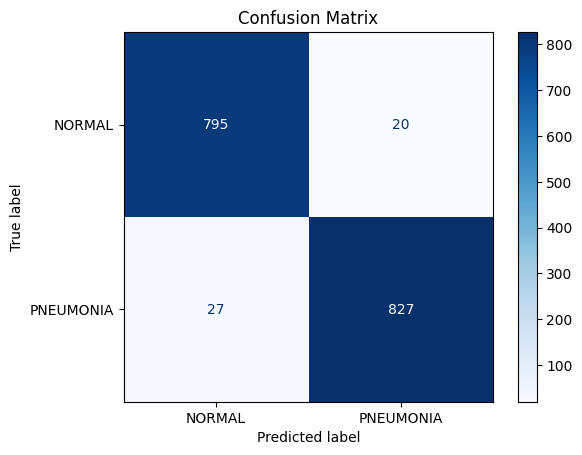

In [13]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# **Evaluation Metrics**
1. **Precision**

Explanation: Precision measures how many of the samples predicted as positive (e.g., "Pneumonia") are actually positive. High precision indicates fewer false alarms.
Why Important?
In medical diagnostics, you want to minimize False Positives, ensuring only truly affected patients are flagged.

2. **Recall**

Explanation: Recall measures how many of the actual positive samples are correctly identified by the model. High recall means the model misses fewer positive cases.
Why Important?
In critical tasks like disease detection, missing a positive case (False Negative) can have severe consequences. High recall ensures that all positive cases are identified.

3. **F1-Score**

Explanation: The F1-Score is the harmonic mean of Precision and Recall. It balances these metrics, providing a single measure of a model’s performance.
Why Important?
It’s especially useful when you need to balance Precision and Recall, ensuring neither False Positives nor False Negatives dominate.

We can show the metrics using the Classification Report, or one by one.

In [15]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

      NORMAL       0.97      0.98      0.97       815
   PNEUMONIA       0.98      0.97      0.97       854

    accuracy                           0.97      1669
   macro avg       0.97      0.97      0.97      1669
weighted avg       0.97      0.97      0.97      1669



In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)
accuracy = accuracy_score(y_true, y_pred_classes)

# Display the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Precision: 0.98
Recall: 0.97
F1-Score: 0.97
Accuracy: 0.97
